# Introduction to  Machine learning with Scikit-Learn

Adapted from [glouppe's tutorial](https://github.com/glouppe/tutorials-scikit-learn/)

## Why Scikit-learn?

* Scikit-learn is the most popular machine learning in Python.
* Simple and efficient algorithm implementations
* Implements a wide variety of well-established machine learning algorithms
* Has extensive <a href="http://scikit-learn.org/dev/documentation.html">documentation</a> 
* Lots of available <a href="http://scikit-learn.org/dev/auto_examples/index.html">examples</a>
* Project is mature and stable and follows srict development guidelines 
* Builds upon NumPy and SciPy 

## Available algorithms

__Supervised learning:__

* Linear models (Ridge, Lasso, Elastic Net, ...)
* Support Vector Machines
* Tree-based methods (Random Forests, Bagging, GBRT, ...)
* Nearest neighbors 
* Neural networks (basics)
* Gaussian Processes
* Feature selection

__Unsupervised learning:__

* Clustering (KMeans, Ward, ...)
* Matrix decomposition (PCA, ICA, ...)
* Density estimation
* Outlier detection

__Model selection and evaluation:__

* Cross-validation
* Grid-search
* Lots of metrics

_... and more!_ (See [Reference](http://scikit-learn.org/dev/modules/classes.html))

## API


All learning algorithms in scikit-learn share a uniform and limited API consisting of complementary interfaces:

- an `estimator` interface for building and fitting models;
- a `predictor` interface for making predictions;
- a `transformer` interface for converting data.

Goal: enforce a simple and consistent API to __make it trivial to swap or plug algorithms__. 

### Estimators

The basic abstraction in sklearn is an estimator. Estimators implement the `fit(X, y=None)` method that fits the model

### Predictors

Predictors use a fitted model to make predictions on data. They implement the `predict(X)` method that returns the predicted `y` values

### Transformers

Transformers change the data to new representations. They implement the `transform(X, y=None)` method that returns the modified data

## Step 0: Classification Framework

Data comes as a finite learning set ${\cal L} = (X, y)$ where
* Input samples are given as an array $X$ of shape `n_samples` $\times$ `n_features`, taking their values in ${\cal X}$;
* Output values are given as an array $y$, taking _symbolic_ values in ${\cal Y}$.

The goal of supervised classification is to build an estimator $\varphi: {\cal X} \mapsto {\cal Y}$ minimizing

$$
Err(\varphi) = \mathbb{E}_{X,Y}\{ \ell(Y, \varphi(X)) \}
$$

where $\ell$ is a loss function, e.g., the zero-one loss for classification $\ell_{01}(Y,\hat{Y}) = 1(Y \neq \hat{Y})$.

## Step 1: Data loading and inspection

- Input data => Numpy arrays or Scipy sparse matrices ;
- $X$ => Data samples. Shape  => `n_samples` $\times$ `n_features`
- $y$ => Labels. Shape => `n_samples`

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
import pprint

bc_data = load_breast_cancer()
X, y = bc_data.data, bc_data.target

print("DATA OVERVIEW")
print("------------------------------------------")

print("X shape: (n_samples) {} x (n_features) {}"
      .format(X.shape[0], X.shape[1]))
print("y shape: (n_samples) {}".format(y.shape[0]))

# set converts a list into a set containing the unique elements in the list
print("Unique labels: {}".format(set(y)))
print("Unique labels: {}".format(bc_data.target_names))

print("------------------------------------------")

print("Features:")
pprint.pprint(bc_data.feature_names)

DATA OVERVIEW
------------------------------------------
X shape: (n_samples) 569 x (n_features) 30
y shape: (n_samples) 569
Unique labels: {0, 1}
Unique labels: ['malignant' 'benign']
------------------------------------------
Features:
array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')


A nice way to gather intuition about the data is to plot the features against each other.

This shows how good we can separate the classes based on the features

First let's define some plotting utilities

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features(X, feature_idx, feature_names, labels):
    fig, ax = plt.subplots()
    zeros = ax.scatter(
        X[y == 0, feature_idx[0]],
        X[y == 0, feature_idx[1]], 
        label=labels[0], c='orange', alpha=0.3, s=100)
    ones = ax.scatter(
        X[y == 1, feature_idx[0]], 
        X[y == 1, feature_idx[1]], 
        label=labels[1], c='b', alpha=0.3, s=100)
    plt.title("{} vs {}".format(feature_names[0], feature_names[1]))
    ax.legend()
    ax.grid(True)
    plt.show()

And plot the features. Note how mean radius and mean perimeter are linearly dependent. Is this a good thing?

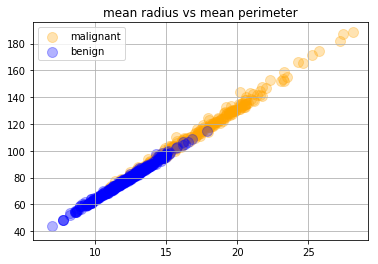

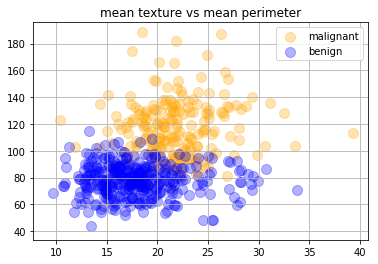

In [3]:
plot_features(
    X, [0, 2],
    [bc_data.feature_names[0], bc_data.feature_names[2]],
    bc_data.target_names)
plot_features(
    X, [1, 2],
    [bc_data.feature_names[1], bc_data.feature_names[2]],
    bc_data.target_names)

## Step 2: Data preprocessing

We can use Transformers to process our data before classifying them to obtain more convenient representations.

A widely used preprocessing step is dimensionality reduction through Principal Component Analysis (PCA). You will learn everything about PCA during the semester.

PCA is useful for visualization or for selecting latent features for classification.

In sklearn, PCA is implemented as a Estimator / Transformer

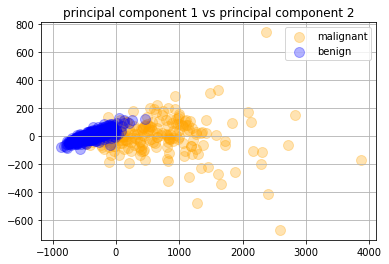

In [4]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X)

plot_features(
    X_pca, [0, 1], 
    ['principal component 1', 'principal component 2'], 
    bc_data.target_names)

Another common preprossecing Transformer is the Standard Scaler which normalizes data to have zero mean and unit std using the transformation

$$
x_{new} = \frac{x_{old} - \mu}{\sigma}
$$

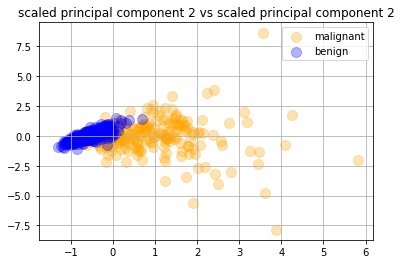

In [5]:
from sklearn.preprocessing import StandardScaler

X_new = StandardScaler().fit_transform(X_pca)

plot_features(
    X_new, [0, 1],
    ['scaled principal component 2', 'scaled principal component 2'], 
    bc_data.target_names)

## Step 3: Fitting the model

First we define some utilities to visualize the classifier's __decision function__.

This shows us where the classifier decides to separate the data into the different classes.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_clf(clf, X, y, labels):
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of Classifier')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    zeros = ax.scatter(
        X0[y == 0], X1[y == 0],
        c='blue', label=labels[0],
        s=60, alpha=0.9, edgecolors='k')
    ones = ax.scatter(
        X0[y == 1], X1[y == 1],
        c='red', label=labels[1], 
        s=60, alpha=0.9, edgecolors='k')
    
    ax.set_ylabel(labels[1])
    ax.set_xlabel(labels[0])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

Now we can fit a Logistic Regression (LR) model to classify the data in the 2 classes. LR tries to model the decision boundary as an hyperplane.

LR implements the Estimator / Predictor methods

Observe LR tries to separate data by drawing a line

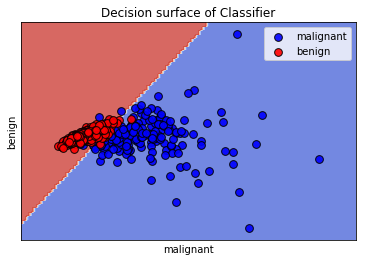

In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_new, y)
plot_clf(clf, X_new, y, bc_data.target_names)

In [8]:
y_pred = clf.predict(X_new[17:27])

y_true = y[17:27]

print("LR - Predicted labels:\t {}".format(y_pred))
print("True labels:\t\t {}".format(y_true))

LR - Predicted labels:	 [0 0 1 1 1 0 0 0 0 0]
True labels:		 [0 0 1 1 1 0 0 0 0 0]


Another commonly used classifier is Support Vector Machines (SVM) that tries to find the hyperplane which has the largest distance to the nearest training points of any class.

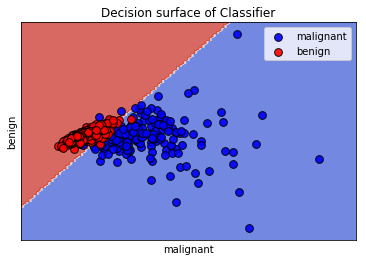

In [9]:
from sklearn.svm import SVC
clf = SVC(kernel="linear")  # try kernel="rbf" instead
clf.fit(X_new, y)
plot_clf(clf, X_new, y, bc_data.target_names)

LR and SVM both try to separate data by drawing a line / hyperplane. Such classifiers are called `linear classifiers`.

We can modify SVM to first project the data using a `kernel`. You will learn about this during the semester.

The important thing here is that with kernels we can get non-linear decision boundaries

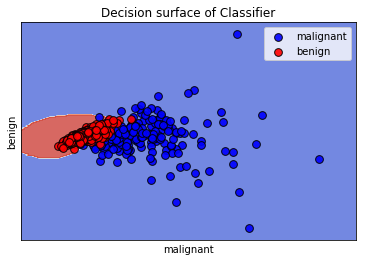

In [10]:
clf = SVC(kernel="rbf")  # try kernel="rbf" instead
clf.fit(X_new, y)
plot_clf(clf, X_new, y, bc_data.target_names)

## Step 4: Model evaluation

- Recall that we want to learn an estimator $\varphi$ minimizing the generalization error $Err(\varphi) = \mathbb{E}_{X,Y}\{ \ell(Y, \varphi(X)) \}$.

- Problem: Since $P_{X,Y}$ is unknown, the generalization error $Err(\varphi)$ cannot be evaluated.

- Solution: Use a proxy to approximate $Err(\varphi)$.

### Error on training data 

A common mistake is to calculate classification error on the training data

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss
clf = LogisticRegression()
clf.fit(X_new, y)
print("Training error =", zero_one_loss(y, clf.predict(X_new)))

Training error = 0.07908611599297011


### Error on test data

Issue: the training error is a __biased__ estimate of the generalization error.

Solution: Divide ${\cal L}$ into two disjoint parts called training and test sets (usually using 70% for training and 30% for test).
- Use the training set for fitting the model;
- Use the test set for evaluation only, thereby yielding an unbiased estimate.

The moded should never see samples from the test dataset

Training error = 0.07511737089201875
Test error = 0.09090909090909094


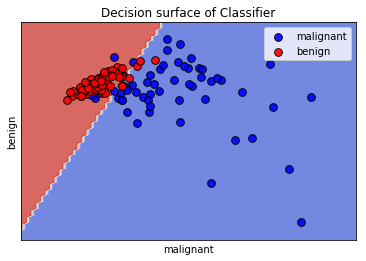

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=2)
clf = LogisticRegression()
clf.fit(X_train, y_train)
print("Training error =", zero_one_loss(y_train, clf.predict(X_train)))
print("Test error =", zero_one_loss(y_test, clf.predict(X_test)))

plot_clf(clf, X_test, y_test, bc_data.target_names)

Summary: Beware of bias when you estimate model performance:
- Training score is often an optimistic estimate of the true performance;
- __The same data should not be used both for training and evaluation.__

### Cross-validation

Issue: 
- When ${\cal L}$ is small, training on 70% of the data may lead to a model that is significantly different from a model that would have been learned on the entire set ${\cal L}$. 
- Yet, increasing the size of the training set (resp. decreasing the size of the test set), might lead to an inaccurate estimate of the generalization error. 

__Hint__: Try to change the `random_state` in the above example and observe the change in the test error and the decision function

Solution: K-Fold cross-validation. 
- Split ${\cal L}$ into K small disjoint folds. 
- Train on K-1 folds, evaluate the test error one the held-out fold.
- Repeat for all combinations and average the K estimates of the generalization error.

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(), X_new, y, 
                         cv=KFold(n_splits=5, random_state=42), 
                         scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.084335 +-0.043503


Try changing the `random_state` in the above example and observe the CV error. 

We can be a lot more confident in the CV error estimate

### Metrics

__Accuracy score__

When evaluating the models we want to report some standard metrics.

The simplest metric for classification is the __accuracy score__, which is the default metric in most models.

The accuracy score is simply the percentage of the correct predictions.

In the case of binary classification is simply $1 - \ell_{01}(Y,\hat{Y})$

In [14]:
print("Accuracy score is classifiers default score. clf.score: {}"
      .format(clf.score(X_test, y_test)))


Accuracy score is classifiers default score. clf.score: 0.9090909090909091


In [15]:
def acc(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.shape[0]

print("We can implement it very easily. acc: {}"
      .format(acc(y_test, clf.predict(X_test))))

We can implement it very easily. acc: 0.9090909090909091


In [16]:
from sklearn.metrics import accuracy_score
print("But it's already implemented in sklearn. accuracy_score: {}"
      .format(accuracy_score(y_test, clf.predict(X_test))))

But it's already implemented in sklearn. accuracy_score: 0.9090909090909091


__Precision, recall and F1 score__

In many cases accuracy is simply not enough to evaluate a classifier. Instead we may need to know how many samples get incorrectly classified as positive (the False Positives $FP$) and how many get classified incorrectly as negative (the False Negatives $FN$).

For example in the malignant vs benign breast cancer we are studying, the consequences are far larger if we missclassify a malignant tumor as benign than if we missclassify a benign tumor as malignant.

The precision, recall and F1 score are metrics that indicate the ratios of False Positives (FP), False Negatives (FN), and True Positive (TP).


$$Precision = \frac{TP}{TP + FP}$$


$$Recall = \frac{TP}{TP + FN}$$

$$F1 = \frac{2 * Precision * Recall}{Precision + Recall}$$

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision =", precision_score(y_test, clf.predict(X_test)))
print("Recall =", recall_score(y_test, clf.predict(X_test)))
print("F1 =", f1_score(y_test, clf.predict(X_test)))

Precision = 0.9204545454545454
Recall = 0.9310344827586207
F1 = 0.9257142857142858


#### Confusion matrix

An even more fine grained metric is the confusion matrix, which shows the number of samples that get missclassified in each class.

Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).[2] The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf.predict(X_test))

array([[49,  7],
       [ 6, 81]])

## Step 5: Model Selection

While there are many points to be covered for model selection, in this tutorial we will consider the __hyperparameter search__.

Hyperparameter search is the problem of finding the best parameters for the model to fit the best performing model.

The simplest solution is to create a grid of all possible parameters and evaluate the model with each set of parameters in the grid, i.e. to perform a grid search.

Sklearn implements grid search as an Estimator.

In [19]:
from sklearn.model_selection import GridSearchCV

# Note in param_grid we pass the names of the parameters we want to search
# as they appear in the classifier's class arguments and the possible values
# they can take
grid = GridSearchCV(LogisticRegression(),
                    param_grid={"C": np.linspace(0.05, 5, 50),
                                "penalty": ["l1", "l2"]},
                    scoring="f1",
                    cv=5, n_jobs=-1)

grid.fit(X_new, y)

print("Best score = {}, Best parameters = {}".format(grid.best_score_, 
                                                     grid.best_params_))

best_params = grid.best_params_

Best score = 0.9428137946665421, Best parameters = {'C': 2.373469387755102, 'penalty': 'l1'}


Question: Should you report the best score as an estimate of the generalization error of the model?

Answer: No

- `grid.best_score_` is not independent from the best model, since its construction was guided by the optimization of this quantity. 

- As a result, the optimized `grid.best_score_` estimate _may_ in fact be a biased, optimistic, estimate of the true performance of the model. 


__Solution__: Use __nested__ cross-validation for correctly selecting the model __and__ correctly evaluating its performance (or use a validation set if you have a lot of data)

In [20]:
grid = GridSearchCV(LogisticRegression(),
                    param_grid={"C": np.linspace(0.05, 5, 50), 
                                "penalty": ["l1", "l2"]},
                    scoring="f1",
                    cv=5, n_jobs=-1)

scores = cross_val_score(grid, X_new, y, cv=5, scoring="f1")

# Unbiased estimate of the accuracy
print("{} +-{}".format(np.mean(scores), np.std(scores)))

0.9405144274803041 +-0.017772311231861404


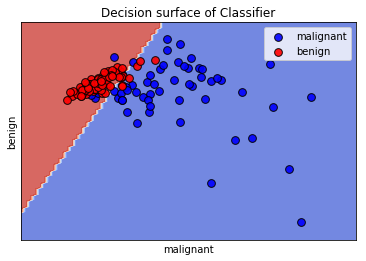

In [21]:
clf = LogisticRegression(**best_params).fit(X_train, y_train)
plot_clf(clf, X_test, y_test, bc_data.target_names)

## Putting it all together: Pipelines

Sklearn introduces the concept of pipelines. Pipelines not only make the code short and easy to understand, but also make it easy to ensure that everything runs on the correct set of data.

For example in the above code we have a serious bug. When we preprocessed PCA and StandardScaler, we used the entire dataset to fit them, not the training dataset.

__Incorrect preprocessing is another way to introduce bias to the models__

or better

__Incorrect preprocessing is the most common way to introduce bias to the models__

or even better

__Incorrect preprocessing is the hardest to spot source of bias for the models__


A correct pipeline should look like this

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer


bc_data = load_breast_cancer()
X, y = bc_data.data, bc_data.target


clf_pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('znorm', StandardScaler()),
    ('lr', LogisticRegression())
])

param_grid = {
    'pca__n_components': [2, 10, 20],
    'lr__C': np.linspace(0.05, 5, 10),
    'lr__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    clf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

best_params = grid_search.fit(X, y).best_params_

best_scores = cross_val_score(grid_search,
                              X, y, 
                              cv=5, 
                              scoring="f1")
import pprint
print("Best model params:")
pprint.pprint(best_params)
print("Best score: {}+-{}".format(np.mean(best_scores), 
                                  np.std(best_scores)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.3s finished


Best model params:
{'lr__C': 2.8, 'lr__penalty': 'l1', 'pca__n_components': 20}
Best score: 0.9721384240941221+-0.011600543381999418


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.3s finished
